In [1]:
# pip install openai
# !pip install python-dotenv

In [2]:
from IPython.display import Image, display

from openai import OpenAI
import base64
import os
import json
from dotenv import load_dotenv

load_dotenv()

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

client = OpenAI(api_key=OPENAI_API_KEY)

In [3]:
PRODUCT_NAME = "NAVI"

PRODUCT_DESC = "A digital assistant that helps users navigate MINDEF/SAF policies quickly and easily"

UNIQUE_SELLING_POINT = "Quick search and answers to MINDEF specific policy questions"

RECOMMENDED_STYLE = "modern, clean, and professional"

DESIRED_OUTCOME = "Increase usage of NAVI application by all MINDEF/SAF personnel"  # not used in the prompt

In [4]:
tagline_prompt = f"""
You are a professional creative copywriter.

Based on the following inputs, generate 3 short, clear, catchy taglines (each under 8 words)
that could be used in marketing materials for a MINDEF/SAF digital tool.

Respond only with a JSON array of strings, like:
["Tagline 1", "Tagline 2", "Tagline 3"]

Product Name: {PRODUCT_NAME}
Product Description: {PRODUCT_DESC}
Unique Selling Point: {UNIQUE_SELLING_POINT}
"""

In [ ]:
def generate_tagline(prompt):
    response = client.responses.create(
        model="gpt-4o",
        input=prompt,
    )
    return json.loads(response.output_text)

In [6]:
tagline_response = generate_tagline(tagline_prompt)
tagline_response

['NAVI: Your MINDEF Policy Shortcut',
 'Fast Answers, Ready for Duty',
 'Navigate MINDEF, Simplified']

In [7]:
SELECTED_TAGLINE = tagline_response[0]

In [8]:
# If the logo image is provided, display it prominently in the infographic.
# If a QR code image is provided, include it at the bottom of the infographic with a tag e.g. "Find out more here".

infographic_prompt = f"""
You are a professional communications designer and marketing copywriter for the Ministry of Defence (MINDEF).

Create a {RECOMMENDED_STYLE} infographics image for the internal launch of a digital tool.

Include all images provided in the appropriate positions. If the image is a logo, it should be display it prominently at the top.

Use the following information to guide your design, but not all needs to be included if they are repeated, irrelevant or redundant:

Product Description: {PRODUCT_DESC}
Unique Selling Point: {UNIQUE_SELLING_POINT}
Tagline: "{SELECTED_TAGLINE}"

Include icons at each section to visually represent the content.

Do not include the words 'Product Name', 'Product Description', 'Unique Selling Point', or 'Tagline' in the design.
"""

In [9]:
# with open("uploaded/product_logo.png", "rb") as logo_file:
#     file_response = client.files.create(
#         file=logo_file,
#         purpose="vision"
#     )
# PRODUCT_LOGO_FILE_ID = file_response.id

In [10]:
# prompt = """Generate a photorealistic image of a gift basket on a white background 
# labeled 'Relax & Unwind' with a ribbon and handwriting-like font."""

# response = client.responses.create(
#     model="gpt-4.1",
#     input=[
#         {
#             "role": "user",
#             "content": [
#                 {"type": "input_text", "text": prompt},
#             ],
#         }
#     ],
#     tools=[{"type": "image_generation"}],
# )

# image_generation_calls = [
#     output
#     for output in response.output
#     if output.type == "image_generation_call"
# ]

# image_data = [output.result for output in image_generation_calls]

# if image_data:
#     image_base64 = image_data[0]
#     with open("gift-basket.png", "wb") as f:
#         f.write(base64.b64decode(image_base64))
# else:
#     print(response.output.content)

In [11]:
# response

In [ ]:
def generate_infographic(
    prompt,
    upload_folder="uploaded",
    previous_response=None
):
    import glob

    # 1. Find and upload all images in the folder (if any)
    file_ids = []
    if os.path.exists(upload_folder):
        image_paths = glob.glob(f"{upload_folder}/*.[pj][pn]g")
        for path in image_paths:
            with open(path, "rb") as img_file:
                file_response = client.files.create(file=img_file, purpose="vision")
                file_ids.append(file_response.id)

    # 2. Build the content list
    content = [{"type": "input_text", "text": prompt}]
    for file_id in file_ids:
        content.append({"type": "input_image", "file_id": file_id})

    # 3. Prepare API call
    api_args = {
        # "model": "gpt-4.1-mini",
        "model": "gpt-4.1",
        "tools": [{"type": "image_generation"}],
    }
    if previous_response is not None:
        api_args["previous_response_id"] = previous_response.id
    
    api_args["input"] = [{"role": "user", "content": content}]

    # 4. Call the API
    response = client.responses.create(**api_args)

    image_data = [
        output.result
        for output in response.output
        if output.type == "image_generation_call"
    ]

    if not image_data:
        print("Warning: No image data returned by the image_generation tool.")
        return response.output_text, None

    image_base64 = image_data[0]
    with open("infographic.png", "wb") as f:
        f.write(base64.b64decode(image_base64))

    return response, image_base64

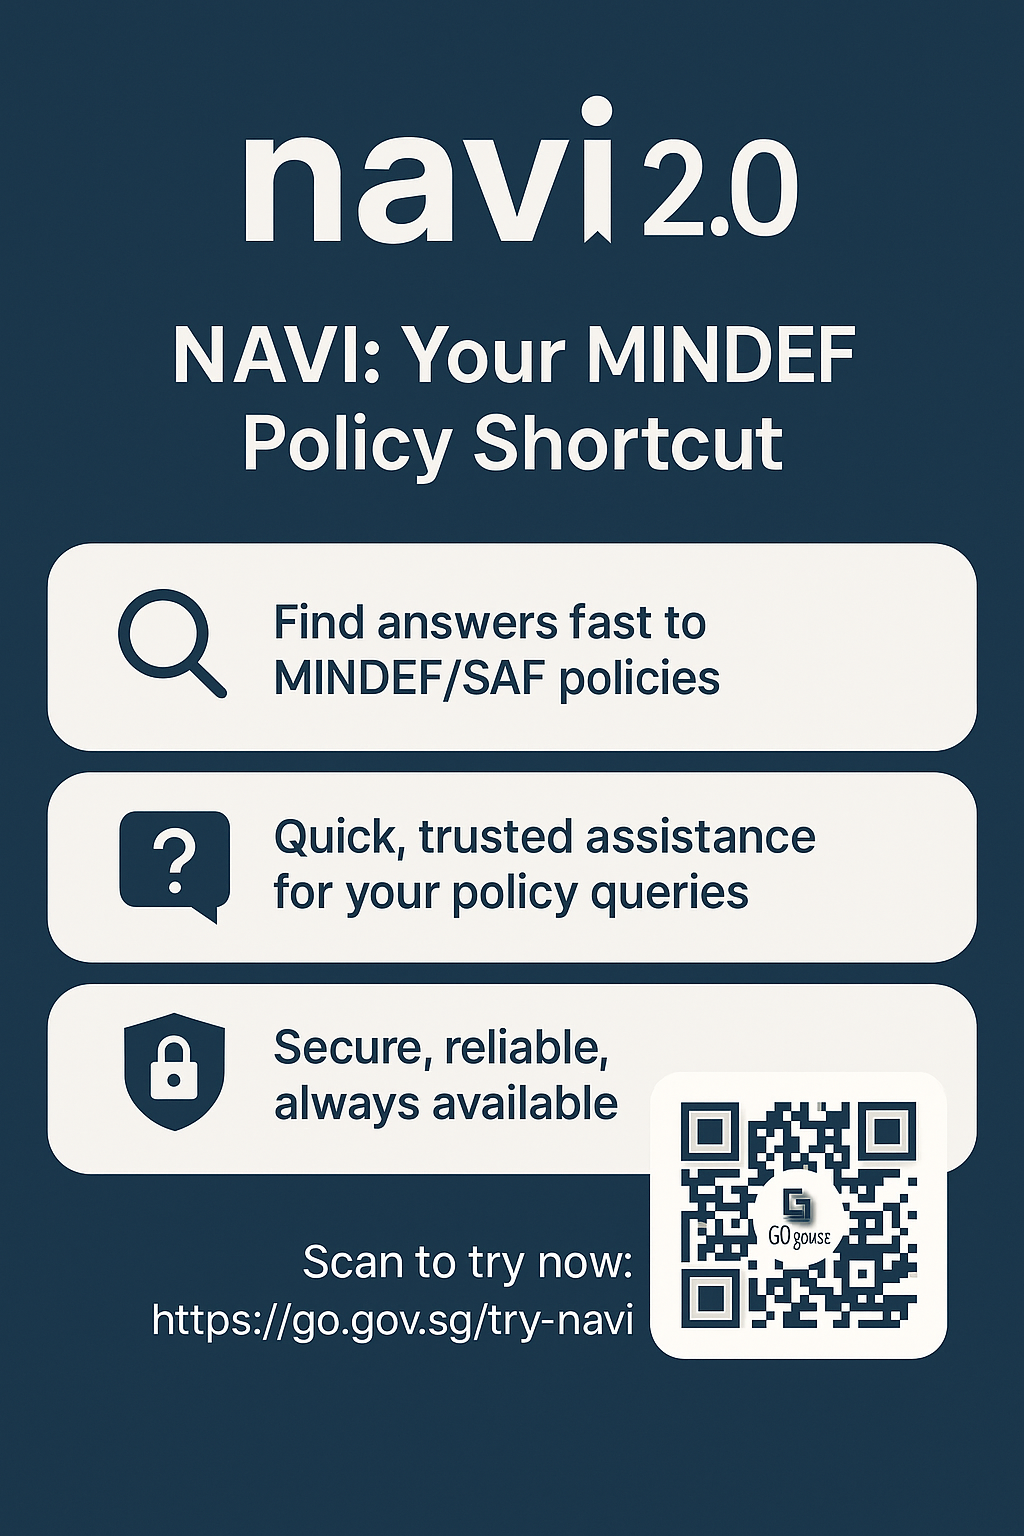

In [13]:
response, generated_infographics = generate_infographic(infographic_prompt, upload_folder="uploaded")

display(Image(data=base64.b64decode(generated_infographics)))

In [14]:
# def generate_followup_image(prompt, response, image_file_id=None):
#     if image_file_id is None:
#         response_fwup = client.responses.create(
#             model="gpt-4.1-mini",
#             previous_response_id=response.id,
#             input=prompt,
#             tools=[{"type": "image_generation"}],
#         )
#     else:
#         response_fwup = client.responses.create(
#             model="gpt-4.1-mini",
#             previous_response_id=response.id,
#             input=[
#                 {
#                     "role": "user",
#                     "content": [
#                         {"type": "input_text", "text": prompt},
#                         {
#                             "type": "input_image",
#                             "file_id": image_file_id,
#                         },
#                     ],
#                 }
#             ],
#             tools=[
#                 {
#                     "type": "image_generation",
#                     # "quality": "medium"
#                 }
#             ],
#         )

#     image_data_fwup = [
#         output.result
#         for output in response_fwup.output
#         if output.type == "image_generation_call"
#     ]

#     if image_data_fwup:
#         image_base64 = image_data_fwup[0]
#         with open("infographic_r2.png", "wb") as f:
#             f.write(base64.b64decode(image_base64))

#     return response_fwup, image_base64

In [15]:
follow_up_prompt = "Change the background to maroon and include more borders"

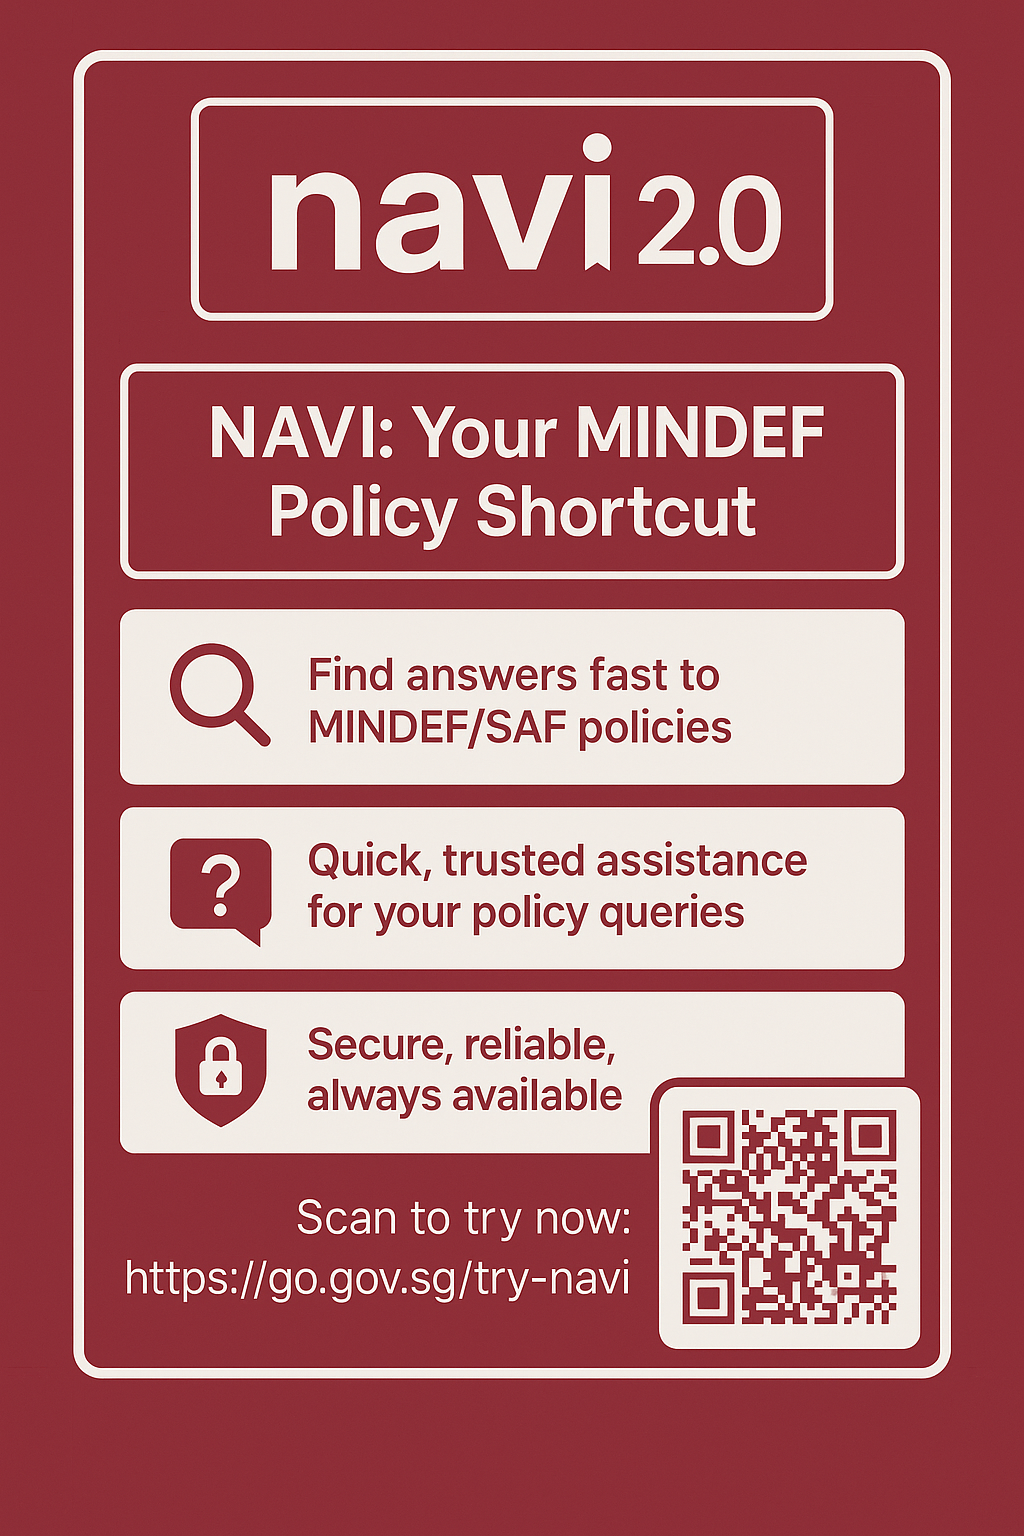

In [16]:
response, generated_infographics = generate_infographic(follow_up_prompt, upload_folder="uploaded2", previous_response=response)

display(Image(data=base64.b64decode(generated_infographics)))